In [19]:
import sys
print(sys.executable)

d:\Kuliah Semester 4\Natural Language Processing\Project Kelompok\.venv\Scripts\python.exe


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

base_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

normalize = transforms.Normalize((0.5,), (0.5,))

normalized_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

augment_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

transform_variations = {
    "Base": base_transform,
    "Normalized": normalized_transform,
    "Normalized + Augment": augment_transform,
    "Normalized + Augment + Regularize": augment_transform  # regularization in model, not transform
}

def train_fine_tuning(model, train_loader, val_loader, epochs=10, lr=1e-4, regularize=False, history=None):
    
    for param in model.parameters():
        param.requires_grad = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4 if regularize else 0.0)

    if history is None or not all(k in history for k in ['train_loss', 'train_acc', 'val_acc']):
        history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
           images, labels = images.to(device), labels.to(device)
           optimizer.zero_grad()
           outputs = model(images)
           loss = criterion(outputs, labels)
           loss.backward()
           optimizer.step()

           running_loss += loss.item()
           _, preds = torch.max(outputs, 1)
           correct_train += (preds == labels).sum().item()
           total_train += labels.size(0)
    
        avg_loss = running_loss / len(train_loader)
        train_acc = 100 * correct_train/total_train
        val_acc, _, _ = evaluate(model, val_loader)

        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'epoch [{epoch+1}/{epochs}] - loss: {avg_loss:.4f} | train acc: {train_acc:.2f}% | val acc: {val_acc:.2f}%')
    return history


def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    acc = 100 * correct / total
    return acc, np.array(all_preds), np.array(all_labels)



In [23]:
# #model
# model = models.resnet18(weights='IMAGENET1K_V1')
# model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, 10)
# model = model.to(device)

In [24]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach().clone()
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach().clone()
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_image, target_class=None):
        self.model.zero_grad()
        output = self.model(input_image)
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        loss = output[0, target_class]
        loss.backward()

        if self.gradients is None:
            raise RuntimeError("Gradients were not captured. Check target_layer or hooks.")

        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1).squeeze()
        cam = F.relu(cam)
        cam -= cam.min()
        cam /= cam.max()
        cam = cam.cpu().numpy()
        return cam, target_class


In [25]:
def gradcam_evaluate(model, data):
    model.eval()
    data = data.to(device)
    data.requires_grad_()  # ✅ needed for Grad-CAM
    target_layer = model.layer4[-1]  # example for ResNet
    grad_cam = GradCAM(model, target_layer)
    cam, cls = grad_cam.generate(data)
    return cam, cls

In [26]:
def plot_training_progress(history_dict):
    """
    history_dict = {
        "Baseline": {"train_acc": [...], "val_acc": [...]},
        "Normalized": {"train_acc": [...], "val_acc": [...]},
        "Augment + Normalize": {...},
        ...
    }
    """
    plt.figure(figsize=(8,6))
    for name, history in history_dict.items():
        plt.plot(history["val_acc"], label=f"{name} (Val)")
        plt.plot(history["train_acc"], '--', alpha=0.5, label=f"{name} (Train)")
    
    plt.title("Training Progress Across Model Variations")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


🔹 Running Base dataset
epoch [1/10] - loss: 0.0785 | train acc: 98.16% | val acc: 99.22%
epoch [2/10] - loss: 0.0156 | train acc: 99.55% | val acc: 99.33%
epoch [3/10] - loss: 0.0101 | train acc: 99.73% | val acc: 99.28%
epoch [4/10] - loss: 0.0066 | train acc: 99.81% | val acc: 99.42%
epoch [5/10] - loss: 0.0054 | train acc: 99.85% | val acc: 99.35%
epoch [6/10] - loss: 0.0034 | train acc: 99.90% | val acc: 99.22%
epoch [7/10] - loss: 0.0063 | train acc: 99.81% | val acc: 99.35%
epoch [8/10] - loss: 0.0038 | train acc: 99.88% | val acc: 99.38%
epoch [9/10] - loss: 0.0036 | train acc: 99.90% | val acc: 99.31%
epoch [10/10] - loss: 0.0028 | train acc: 99.94% | val acc: 99.32%
✅ Base Test Accuracy: 99.55%


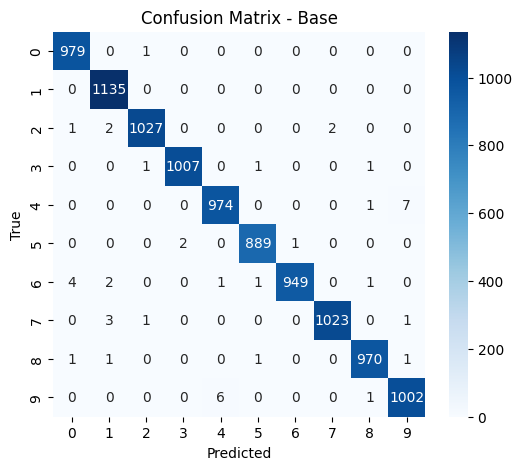

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_37032\730305514.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


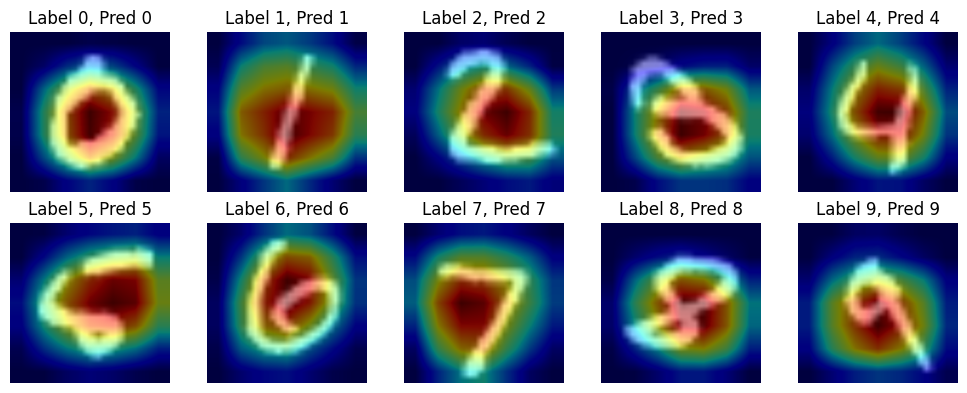


🔹 Running Normalized dataset
epoch [1/10] - loss: 0.0796 | train acc: 98.04% | val acc: 99.26%
epoch [2/10] - loss: 0.0151 | train acc: 99.58% | val acc: 99.36%
epoch [3/10] - loss: 0.0087 | train acc: 99.76% | val acc: 99.37%
epoch [4/10] - loss: 0.0067 | train acc: 99.80% | val acc: 99.55%
epoch [5/10] - loss: 0.0062 | train acc: 99.82% | val acc: 99.23%
epoch [6/10] - loss: 0.0057 | train acc: 99.81% | val acc: 99.43%
epoch [7/10] - loss: 0.0057 | train acc: 99.81% | val acc: 99.53%
epoch [8/10] - loss: 0.0036 | train acc: 99.89% | val acc: 99.55%
epoch [9/10] - loss: 0.0037 | train acc: 99.90% | val acc: 99.44%
epoch [10/10] - loss: 0.0026 | train acc: 99.92% | val acc: 99.56%
✅ Normalized Test Accuracy: 99.62%


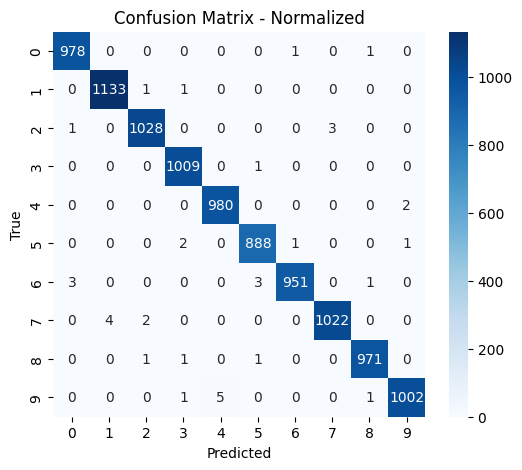

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_37032\730305514.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


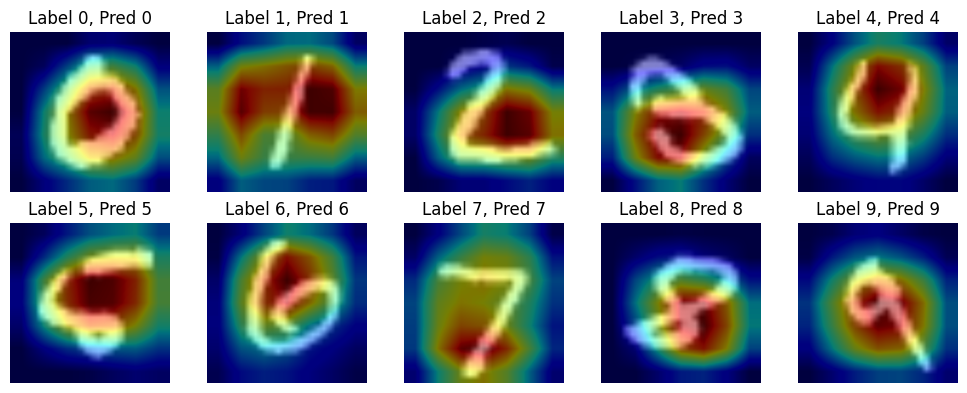


🔹 Running Normalized + Augment dataset
epoch [1/10] - loss: 0.1341 | train acc: 96.37% | val acc: 98.50%
epoch [2/10] - loss: 0.0423 | train acc: 98.68% | val acc: 98.65%
epoch [3/10] - loss: 0.0323 | train acc: 99.02% | val acc: 98.93%
epoch [4/10] - loss: 0.0275 | train acc: 99.14% | val acc: 98.84%
epoch [5/10] - loss: 0.0224 | train acc: 99.31% | val acc: 99.10%
epoch [6/10] - loss: 0.0197 | train acc: 99.39% | val acc: 98.97%
epoch [7/10] - loss: 0.0172 | train acc: 99.46% | val acc: 98.83%
epoch [8/10] - loss: 0.0162 | train acc: 99.52% | val acc: 98.91%
epoch [9/10] - loss: 0.0144 | train acc: 99.51% | val acc: 99.06%
epoch [10/10] - loss: 0.0129 | train acc: 99.61% | val acc: 99.15%
✅ Normalized + Augment Test Accuracy: 99.02%


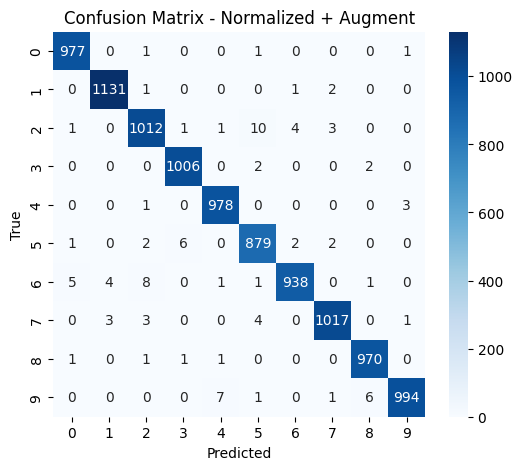

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_37032\730305514.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


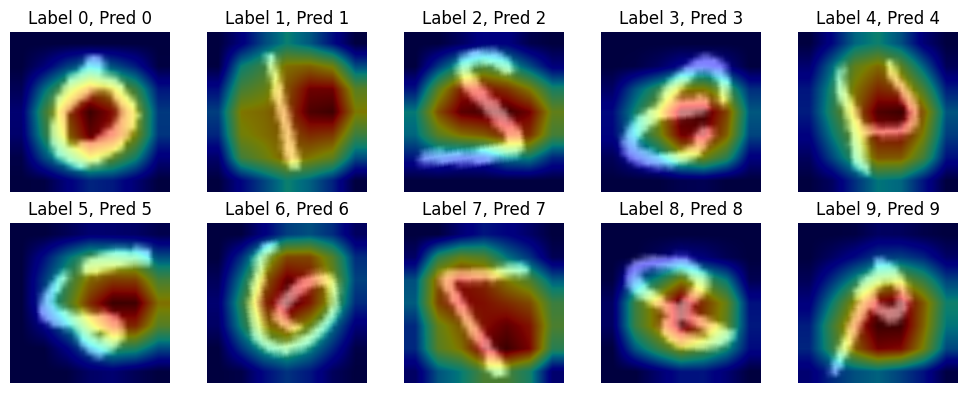


🔹 Running Normalized + Augment + Regularize dataset
epoch [1/10] - loss: 0.1575 | train acc: 95.51% | val acc: 98.22%
epoch [2/10] - loss: 0.0462 | train acc: 98.60% | val acc: 98.62%
epoch [3/10] - loss: 0.0368 | train acc: 98.90% | val acc: 98.96%
epoch [4/10] - loss: 0.0309 | train acc: 99.02% | val acc: 98.92%
epoch [5/10] - loss: 0.0249 | train acc: 99.27% | val acc: 98.97%
epoch [6/10] - loss: 0.0218 | train acc: 99.34% | val acc: 98.97%
epoch [7/10] - loss: 0.0190 | train acc: 99.40% | val acc: 98.93%
epoch [8/10] - loss: 0.0169 | train acc: 99.50% | val acc: 98.95%
epoch [9/10] - loss: 0.0171 | train acc: 99.49% | val acc: 99.04%
epoch [10/10] - loss: 0.0155 | train acc: 99.47% | val acc: 99.08%
✅ Normalized + Augment + Regularize Test Accuracy: 98.99%


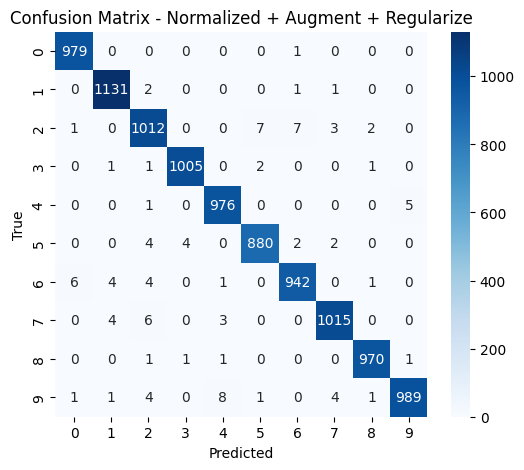

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_37032\730305514.py:54: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  idx = np.where(np.array(test_dataset.targets) == i)[0][0]


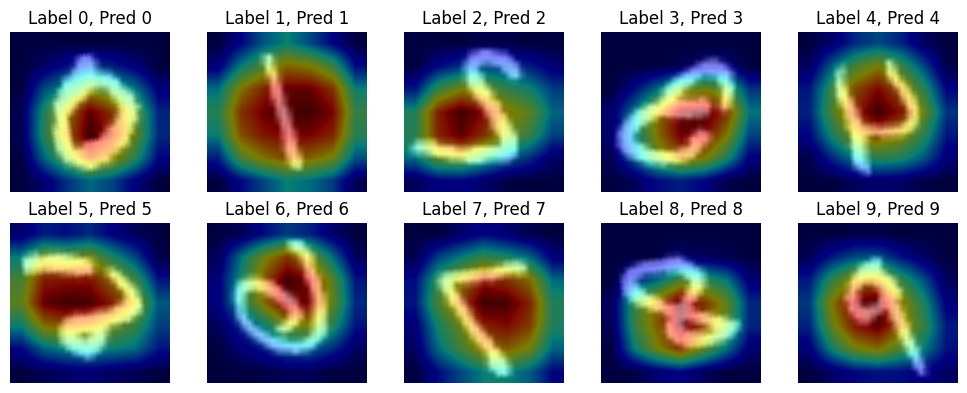

In [27]:
results = []
histories = {}  # store per-variation accuracy history

for variation_name, transform in transform_variations.items():
    print(f"\n🔹 Running {variation_name} dataset")

    # ---- Dataset split ----
    dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

    # ---- Model setup ----
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Sequential(
        nn.Dropout(0.5 if "Regularize" in variation_name else 0.0),
        nn.Linear(model.fc.in_features, 10)
    )
    model = model.to(device)

    # ---- Train & Track ----
    history = {}
    history = train_fine_tuning(model, train_loader, val_loader, epochs=10, lr=1e-4, history=history)

    # ---- Evaluate on Test Set ----
    test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    test_acc, preds, labels = evaluate(model, test_loader)
    print(f"✅ {variation_name} Test Accuracy: {test_acc:.2f}%")

    # ---- Confusion Matrix ----
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {variation_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ---- Store results ----
    results.append({"Variation": variation_name, "Accuracy": test_acc})
    histories[variation_name] = history

    # ---- Grad-CAM Visualizations ----
    grad_cam = GradCAM(model, model.layer4[-1].conv2)
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,4))
    axes_flat = axes.flatten()

    for i in range(10):
        ax = axes_flat[i]
        idx = np.where(np.array(test_dataset.targets) == i)[0][0]
        img, _ = test_dataset[idx]
        input_tensor = img.unsqueeze(0).to(device)
        input_tensor.requires_grad_()
        cam, cls = grad_cam.generate(input_tensor)
        cam_resized = cv2.resize(cam, (img.shape[2], img.shape[1]))

        ax.imshow(img.squeeze().cpu().numpy(), cmap="gray")
        ax.imshow(cam_resized, cmap="jet", alpha=0.5)
        ax.set_title(f"Label {i}, Pred {cls}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

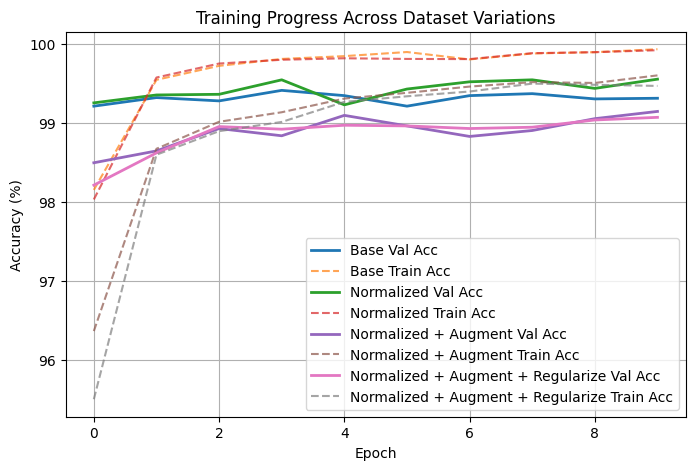

In [28]:
plt.figure(figsize=(8,5))
for variation_name, history in histories.items():
    plt.plot(history["val_acc"], label=f"{variation_name} Val Acc", linewidth=2)
    plt.plot(history["train_acc"], linestyle="--", alpha=0.7, label=f"{variation_name} Train Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training Progress Across Dataset Variations")
plt.legend()
plt.grid(True)
plt.show()

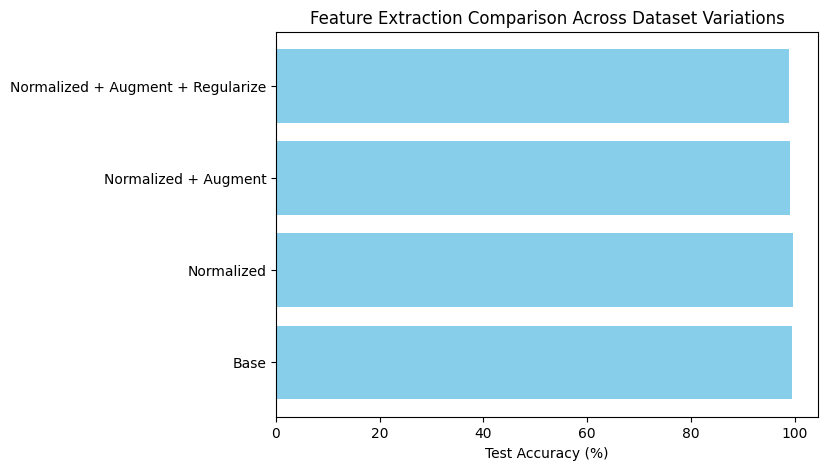

In [29]:
plt.figure(figsize=(7,5))
names = [r["Variation"] for r in results]
values = [r["Accuracy"] for r in results]
plt.barh(names, values, color='skyblue')
plt.xlabel("Test Accuracy (%)")
plt.title("Feature Extraction Comparison Across Dataset Variations")
plt.show()